## import data

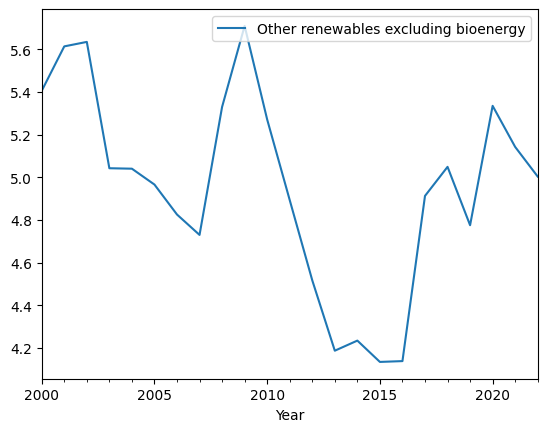

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset/share-elec-by-source.csv')
df = df[df['Entity'] == 'Indonesia']
df = df.drop('Code', axis=1)
#df.reset_index(drop=True, inplace=True)
df.columns = df.columns.str.replace(' - % electricity', '')
df = df.fillna(0)
df = df.drop('Entity', axis=1)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.set_index('Year')['Other renewables excluding bioenergy']
df = pd.DataFrame(df)
df = df[df['Other renewables excluding bioenergy'] != 0]
df.plot()
plt.show()

## Check Stationer

In [2]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Other renewables excluding bioenergy'])

# Menampilkan hasil uji
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpretasi hasil
alpha = 0.05
if result[1] < alpha:
    print("Reject the null hypothesis (H0), the data is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the data is non-stationary.")

ADF Statistic: -7.538654827034178
p-value: 3.424395707938704e-11
Critical Values:
   1%: -4.068853732362312
   5%: -3.1271488757396453
   10%: -2.7017297633136095
Reject the null hypothesis (H0), the data is stationary.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

print('Data split into training and testing sets.')
print('Training set size:', len(train))
print('Testing set size:', len(test))

Data split into training and testing sets.
Training set size: 18
Testing set size: 5


## Search p,d,q

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

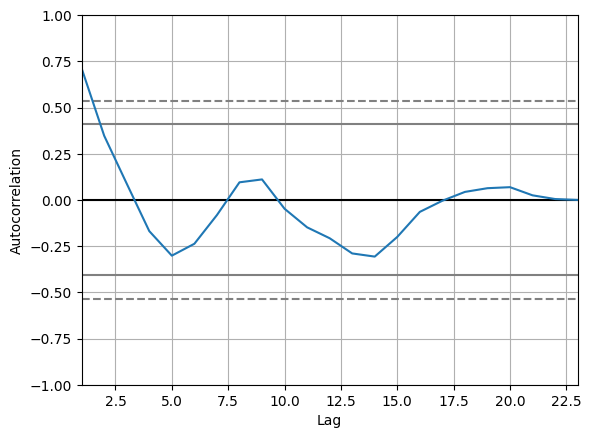

In [4]:
pd.plotting.autocorrelation_plot(df)

p=3

q=1

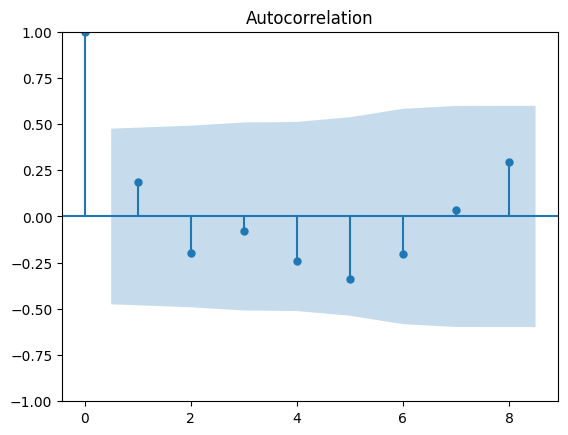

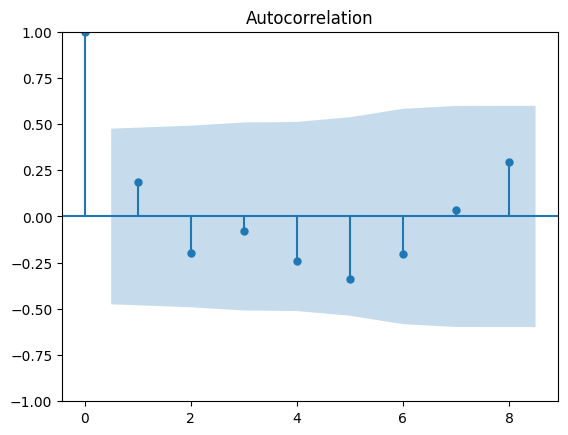

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train.diff().dropna())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=31.610, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=31.333, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=29.637, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.424 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -13.818
Date:                Thu, 16 May 2024   AIC                             29.637
Time:                        06:51:52   BIC                             30.681
Sample:                    01-01-2000   HQIC                            29.863
                         - 01-01-2022                                         
Covariance Ty

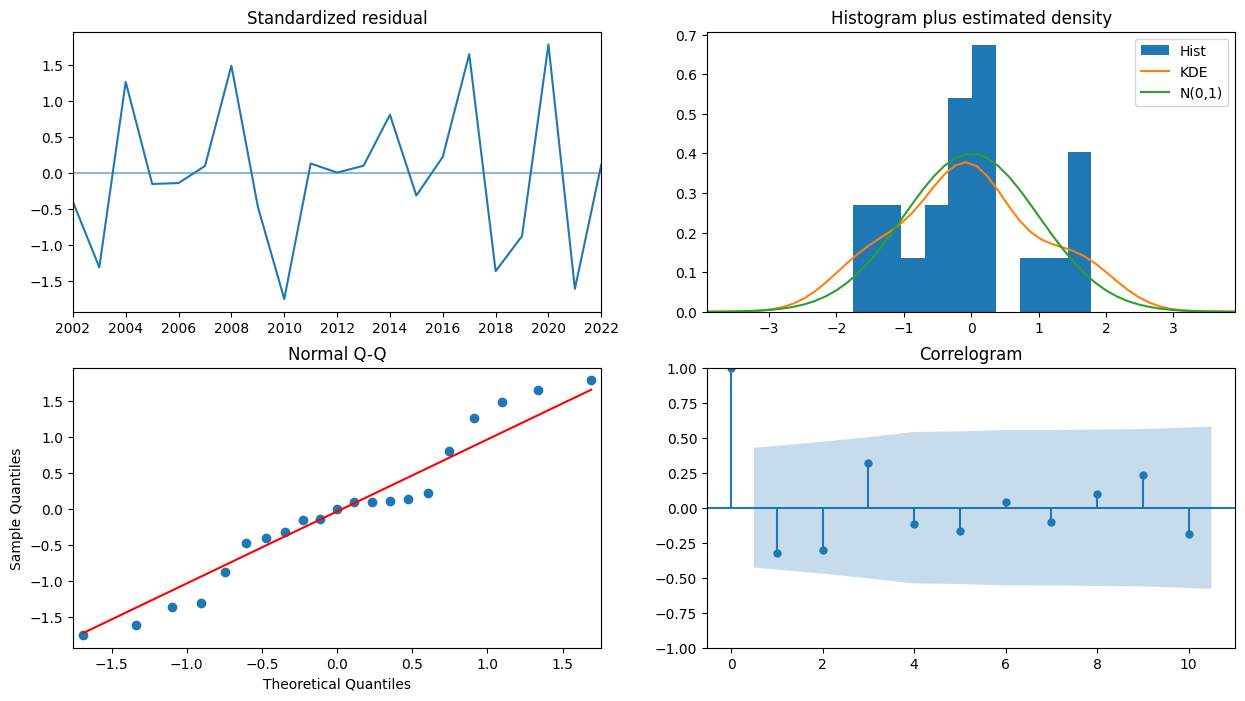

In [6]:
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
model_autoARIMA = auto_arima(df, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [7]:
model_autoARIMA

ARIMA(order=(0, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Arima fit

c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


                                        SARIMAX Results                                         
Dep. Variable:     Other renewables excluding bioenergy   No. Observations:                   18
Model:                                   ARIMA(3, 1, 1)   Log Likelihood                  -5.081
Date:                                  Thu, 16 May 2024   AIC                             20.161
Time:                                          06:51:53   BIC                             24.328
Sample:                                      01-01-2000   HQIC                            20.576
                                           - 01-01-2017                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1830      1.224     -0.149      0.881      -2.582

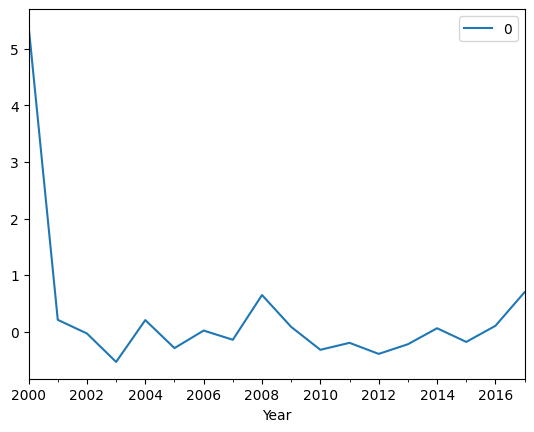

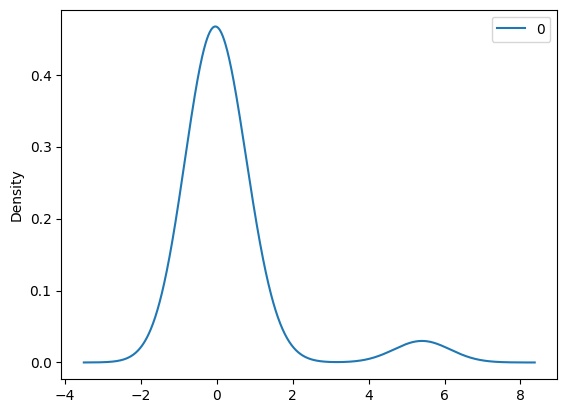

               0
count  18.000000
mean    0.283077
std     1.318854
min    -0.536402
25%    -0.217522
50%    -0.007749
75%     0.178145
max     5.405957


In [8]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot
p,d,q = 3,1,1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# summary stats of residuals
print(residuals.describe())

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot as plt

# Fit the ARIMA model
model = ARIMA(train, order=(3, 1, 1))
model_fit = model.fit()

forecast = pd.DataFrame(model_fit.forecast(steps=5))
forecast.columns = ['Renewables (% equivalent primary energy)']
forecast.index.name = 'Year'

# Calculate RMSE
error = mean_squared_error(test, forecast)
rmse = np.sqrt(error)
print("RMSE: ", rmse)

RMSE:  0.20225534049587615


c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


## Forecast

In [10]:
forecast = pd.DataFrame(model_fit.forecast(steps=5))
forecast.columns = ['Other renewables excluding bioenergy']
forecast.index.name = 'Year'
forecast

,Other renewables excluding bioenergy
Year,
2018-01-01,5.192724
2019-01-01,5.015602
2020-01-01,4.999035
2021-01-01,5.029618
2022-01-01,5.027521


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Menghitung metrik evaluasi
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.17124348543536866
Mean Squared Error (MSE): 0.040907222759102795
Root Mean Squared Error (RMSE): 0.20225534049587615


<function matplotlib.pyplot.show(close=None, block=None)>

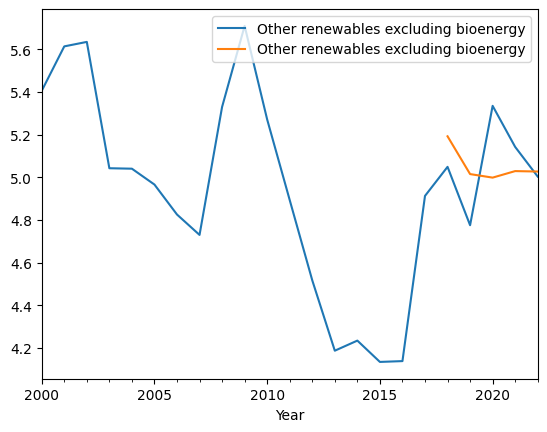

In [12]:
data = pd.concat([df, forecast], axis=1)
data
data.plot()
plt.show

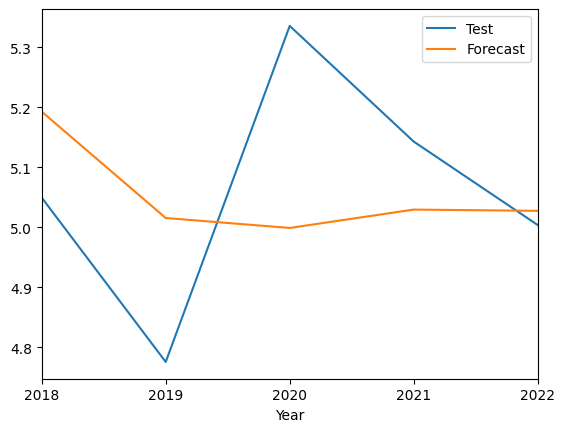

In [13]:
compare = pd.concat([test, forecast], axis=1)
compare.columns = ['Test', 'Forecast']
compare.plot()
plt.show()

In [14]:
compare['Error'] = np.abs((compare['Test'] - compare['Forecast']) / compare['Test']) * 100
compare

,Test,Forecast,Error
Year,,,
2018-01-01,5.049508,5.192724,2.836239
2019-01-01,4.775927,5.015602,5.018392
2020-01-01,5.335481,4.999035,6.305826
2021-01-01,5.142876,5.029618,2.202219
2022-01-01,5.003898,5.027521,0.472093


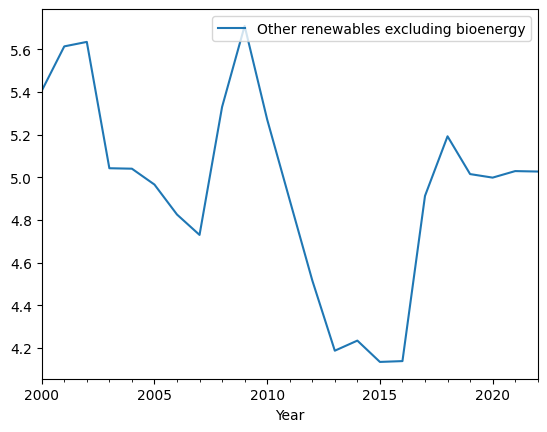

In [15]:
data = pd.concat([train, forecast])
data.plot()
plt.show()

## Evaluation

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Menghitung metrik evaluasi
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.17124348543536866
Mean Squared Error (MSE): 0.040907222759102795
Root Mean Squared Error (RMSE): 0.20225534049587615


In [19]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found. Using zeros as starting parameters.")

arima_orders = [(0, 0, 1), (3, 1, 1), (3, 2, 2)]
rmse_results = {}

for order in arima_orders:
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = pd.DataFrame(model_fit.forecast(steps=5))
    forecast.columns = ['Renewables (% equivalent primary energy)']
    forecast.index.name = 'Year'
    rmse = np.sqrt(mean_squared_error(test, forecast))
    rmse_results[order] = rmse
    print(f'Root Mean Squared Error (RMSE) for ARIMA{order}:', rmse)

print("\nRMSE Results for each ARIMA order:")
for order, rmse in rmse_results.items():
    print(f'ARIMA{order}: {rmse}')

Root Mean Squared Error (RMSE) for ARIMA(0, 0, 1): 0.2117311893863806
Root Mean Squared Error (RMSE) for ARIMA(3, 1, 1): 0.20225534049587615


c:\Users\M S I\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Root Mean Squared Error (RMSE) for ARIMA(3, 2, 2): 0.20918819904365868

RMSE Results for each ARIMA order:
ARIMA(0, 0, 1): 0.2117311893863806
ARIMA(3, 1, 1): 0.20225534049587615
ARIMA(3, 2, 2): 0.20918819904365868
